In [1]:
%pip install pandas seaborn folium

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Cargamos las librerías que necesitaremos 
import pandas as pd
import math
from math import radians, cos, sin, sqrt, atan2 
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from IPython.display import display

In [3]:
#Cargamos los archivos que utilizaremos para el análisis
fiscalias = pd.read_csv('/Users/ximenagarcia/Downloads/servicios_y_sedes_fgj.csv')
estaciones = pd.read_csv('/Users/ximenagarcia/Downloads/data-2026-01-31.csv')
viajes = pd.read_csv('/Users/ximenagarcia/Downloads/2024-11.csv')

In [4]:
#Verificamos nuestras bases de datos
fiscalias.info()
estaciones.info()
viajes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         108 non-null    int64  
 1   tipo_de_servicio           108 non-null    object 
 2   sede                       107 non-null    object 
 3   objeto_de_la_atencion      107 non-null    object 
 4   full_address               108 non-null    object 
 5   calle                      108 non-null    object 
 6   numero_exterior            108 non-null    object 
 7   numero_interior            108 non-null    object 
 8   colonia                    108 non-null    object 
 9   codigo_postal              108 non-null    int64  
 10  alcaldia                   108 non-null    object 
 11  referencias_de_ubicacion   91 non-null     object 
 12  horario_de_atencion_horas  108 non-null    object 
 13  dias_de_atencion           108 non-null    object 

Como nuestro objeto de estudio solo son 100 viajes, vamos seleccionar 100 datos aleatorios de nuestra base de datos viajes. 

In [5]:
muestra = viajes.sample(n=100).reset_index(drop=True)
muestra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Genero_Usuario         100 non-null    object 
 1   Edad_Usuario           100 non-null    float64
 2   Bici                   100 non-null    int64  
 3   Ciclo_Estacion_Retiro  100 non-null    object 
 4   Fecha_Retiro           100 non-null    object 
 5   Hora_Retiro            100 non-null    object 
 6   Ciclo_EstacionArribo   100 non-null    object 
 7   Fecha_Arribo           100 non-null    object 
 8   Hora_Arribo            100 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 7.2+ KB


### Análisis Exploratorio


In [6]:
#Vamos a unir nuestros DataFrames para tener acceso a la información de ubicación de nuestros 100 viajes. 
estaciones_retiro = estaciones [['num_cicloe','latitud','longitud']].copy()
estaciones_retiro.rename(columns={
    'num_cicloe':'Ciclo_Estacion_Retiro',
    'latitud':'lat_retiro',
    'longitud':'lon_retiro'
},inplace=True)

estaciones_arribo = estaciones [['num_cicloe','latitud','longitud']].copy()
estaciones_arribo.rename(columns={
    'num_cicloe':'Ciclo_EstacionArribo',
    'latitud':'lat_arribo',
    'longitud':'lon_arribo'
},inplace=True)

muestra = muestra.merge(estaciones_retiro, on ='Ciclo_Estacion_Retiro', how='left')
muestra = muestra.merge(estaciones_arribo, on ='Ciclo_EstacionArribo', how='left')

muestra.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_EstacionArribo,Fecha_Arribo,Hora_Arribo,lat_retiro,lon_retiro,lat_arribo,lon_arribo
0,M,29.0,7205859,591,13/11/2024,05:42:02,397,13/11/2024,06:04:09,19.402088,-99.142976,19.373112,-99.166981
1,M,27.0,4618344,116,01/11/2024,13:21:20,255,01/11/2024,13:29:41,19.428985,-99.156640,19.437118,-99.161862
2,M,21.0,8383853,706,07/11/2024,08:12:54,317,07/11/2024,08:36:55,19.347503,-99.152440,19.391456,-99.166157
3,F,23.0,8816613,194,15/11/2024,15:43:22,035,15/11/2024,16:08:25,19.424282,-99.180334,19.424558,-99.163518
4,M,27.0,8290579,420,06/11/2024,17:26:21,385,06/11/2024,17:34:16,19.369782,-99.179707,19.375806,-99.185527


In [7]:
def distancia_km(lat1, lon1, lat2, lon2):
    R=6371
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat=lat2-lat1
    dlon=lon2-lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
    c = 2*math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R*c


In [8]:
muestra['distancia_km']=muestra.apply(
    lambda row: distancia_km(row['lat_retiro'], row['lon_retiro'], row['lat_arribo'], row['lon_arribo']),
    axis=1
)

#### Ruta y duración más corta

In [9]:
print('El viaje más corto fue de', muestra['distancia_km'].min())

El viaje más corto fue de 0.0


Es importante mencionar que hay rutas en las que la estación de retiro es igual a la estación de arribo, por lo que la distancia entre esos puntos será igual a 0. Esto no significa que haya sido la ruta más corta. Podemo también considerar el factor del tiempo. 

In [10]:
muestra['Hora_Retiro'] = pd.to_datetime(muestra['Hora_Retiro'], format='%H:%M:%S')
muestra['Hora_Arribo'] = pd.to_datetime(muestra['Hora_Arribo'], format='%H:%M:%S')

def duracion (retiro, arribo):
    delta = arribo - retiro
    return delta.total_seconds() / 60

muestra['duracion_min']=muestra.apply(
    lambda row: duracion(row['Hora_Retiro'],row['Hora_Arribo']),
    axis = 1
)
print('En tiempo, el viaje más corto fue de', muestra['duracion_min'].min())

En tiempo, el viaje más corto fue de 2.45


#### Fiscalía más cercana del punto final de cada ruta

In [11]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R * c

def fiscalia_mas_cercana(lat_arribo, lon_arribo, fiscalias):
    fiscalias['distancia'] = fiscalias.apply(
        lambda row: haversine(lat_arribo, lon_arribo, row['latitude'], row['longitude']),
        axis=1
    )
    return fiscalias.loc[fiscalias['distancia'].idxmin()]['full_address']

muestra['fiscalia_mas_cercana'] = muestra.apply(
    lambda row: fiscalia_mas_cercana(row['lat_arribo'], row['lon_arribo'], fiscalias),
    axis=1
)

muestra[['Ciclo_EstacionArribo','fiscalia_mas_cercana']].head()


,Ciclo_EstacionArribo,fiscalia_mas_cercana
0,397,Avenida División del Norte 1611 S/N Santa Cruz...
1,255,Calle Santa María la Ribera 37 S/N Santa María...
2,317,Calle Enrique Pestalozzi 1115 S/N Del Valle B...
3,035,Amberes 54 S/N Juárez Cuauhtémoc 06600 CDMX
4,385,Batallon de San Patricio S/N S/N Cristo Rey Á...


#### Identificación de patrones espaciales
##### **Estaciones de arrobo y retiro con mayor concentración**

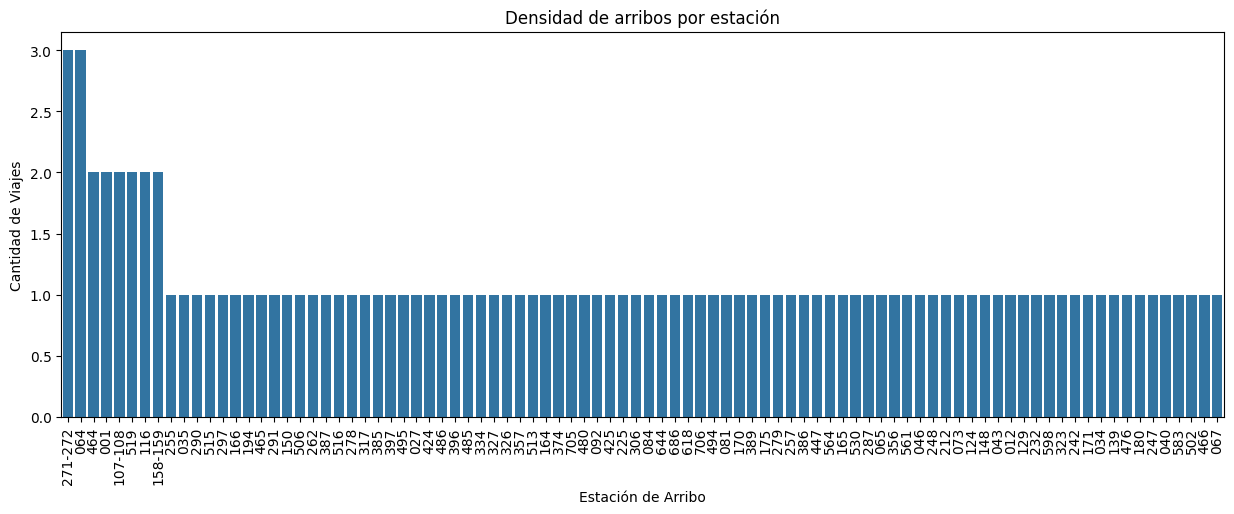

In [12]:
arribos = muestra['Ciclo_EstacionArribo'].value_counts()
plt.figure(figsize=(15,5))
sns.barplot(x=arribos.index, y=arribos.values)
plt.xticks(rotation=90)
plt.xlabel('Estación de Arribo')
plt.ylabel('Cantidad de Viajes')
plt.title('Densidad de arribos por estación')
plt.show()

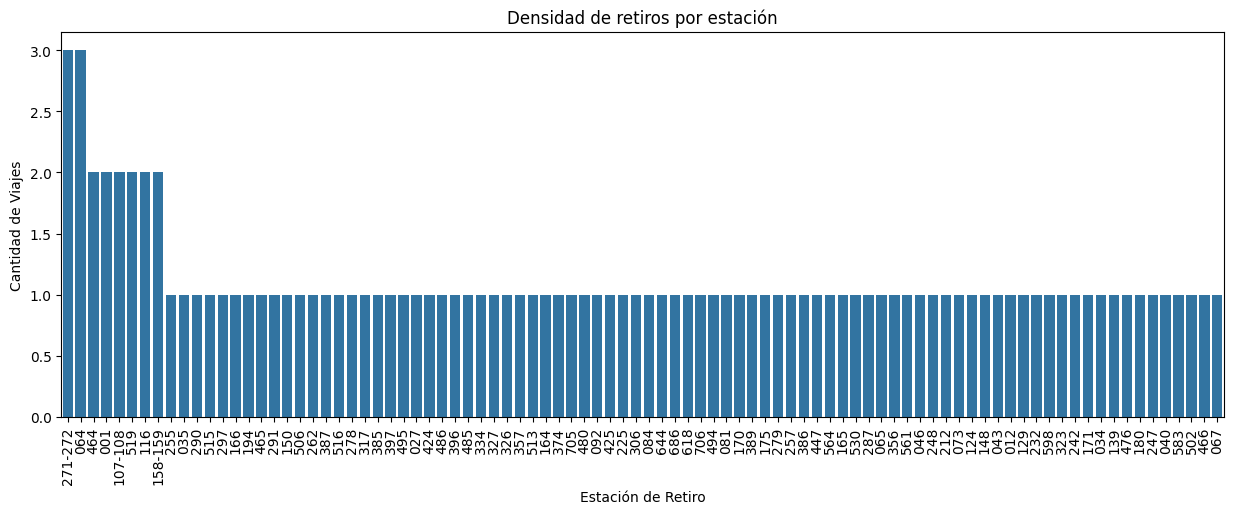

In [13]:
retiros = muestra['Ciclo_Estacion_Retiro'].value_counts()
plt.figure(figsize=(15,5))
sns.barplot(x=arribos.index, y=arribos.values)
plt.xticks(rotation=90)
plt.xlabel('Estación de Retiro')
plt.ylabel('Cantidad de Viajes')
plt.title('Densidad de retiros por estación')
plt.show()

De nuestra muestra de 100 rutas, identificamos que en su mayoría únicamnente se retira y arriba una ecobici por estación. Por lo general las estaciones de retiro más utilizadas son iguales a las estaciones de arribo más utilizadas

##### **Distribuciones de los viajes (km y tiempo en minutos)**

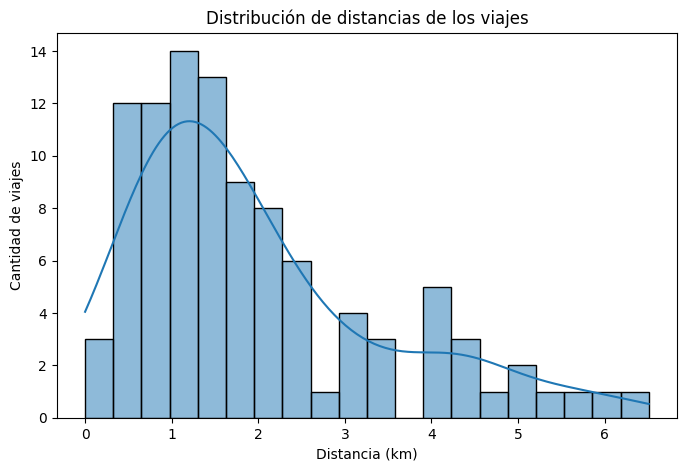

In [14]:
plt.figure(figsize=(8,5))
sns.histplot(muestra['distancia_km'], bins=20, kde=True)
plt.xlabel('Distancia (km)')
plt.ylabel('Cantidad de viajes')
plt.title('Distribución de distancias de los viajes')
plt.show()

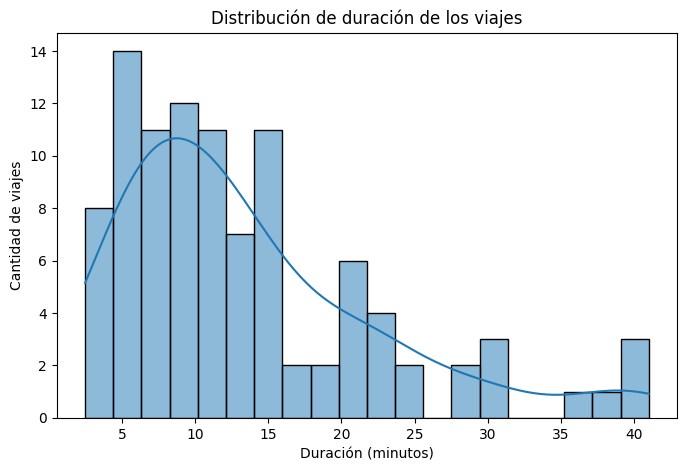

In [15]:
plt.figure(figsize=(8,5))
sns.histplot(muestra['duracion_min'], bins=20, kde=True)
plt.xlabel('Duración (minutos)')
plt.ylabel('Cantidad de viajes')
plt.title('Distribución de duración de los viajes')
plt.show()

En su mayoría los viajes de las ecobicis son de distancias cortas (menos de 10 km). Asimismo, podemos identificar que los viajes también son cortos (con una duración de máximo 10 minutos)

##### **Ditribución de viajes al día**


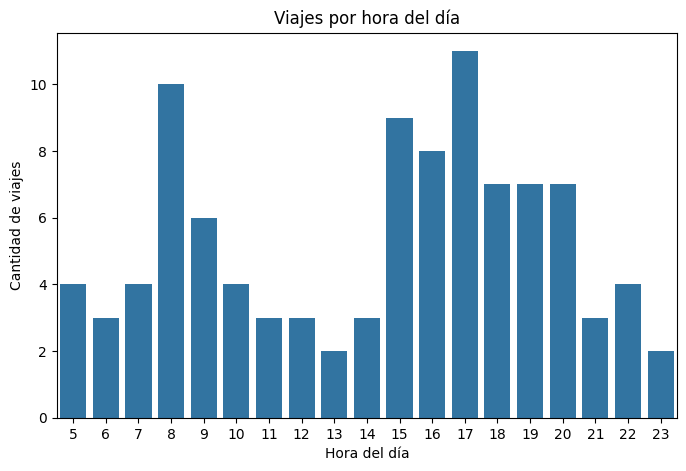

In [16]:
muestra['Hora_Retiro'] = pd.to_datetime(muestra['Hora_Retiro'], format='%H:%M:%S').dt.hour

plt.figure(figsize=(8,5))
sns.countplot(x='Hora_Retiro', data=muestra)
plt.xlabel('Hora del día')
plt.ylabel('Cantidad de viajes')
plt.title('Viajes por hora del día')
plt.show()

La hora de inicio de los viajes es variable, pero pdemos ver más actividad por las mañanas y por la tarde (15 a 17 horas)

In [17]:
mapa = folium.Map(location=[19.4326, -99.1332], zoom_start=12)

for idx, row in muestra.iterrows():
    folium.PolyLine(
        locations=[(row['lat_retiro'], row['lon_retiro']), 
                   (row['lat_arribo'], row['lon_arribo'])],
        color='blue', weight=2, opacity=0.6
    ).add_to(mapa)

mapa.save('flujos.html')
display(mapa)

Finalmente, podemos ver más concentración de los viajes de la ecobici se concentran principalmente en la zona centro de la Ciudad de México. 